In [2]:
import os
from dotenv import load_dotenv
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

load_dotenv()
base_path = os.getenv("BASE_LOCAL_DIR_PATH")

df_data_org = pd.read_json(f"{base_path}project_notebook/collaborative_filtering/data/test.json", lines=True)
df_data_org.head()

,id,user_id,item_id,join
0,0,0,0,0
1,1,0,1,0
2,2,0,1,0
3,3,0,0,0
4,4,0,1,0


## Descriptions
### definitions of each columns
|column|description|type|
|---|---|---|
|id|id of transactions made when item is provided|int|
|user_id|id of user|int|
|item_id|id of provided item|int|
|join|when user select provided item then 1, else 0|bool|

In [4]:
print(f"user_id counts: {df_data_org.user_id.nunique()}")
print(f"item_id counts: {df_data_org.item_id.nunique()}")


id counts: 95993
user_id counts: 70
item_id counts: 1954


In [12]:
print(f"provided counts: {df_data_org.id.nunique()}")
print(f"selection count: {df_data_org['join'].sum()}")
print(f"selection ratio: {round(df_data_org['join'].sum() / df_data_org.id.nunique(),4)*100} %")

provided counts: 95993
selection count: 5346
selection ratio: 5.57 %


## Main Goal
- Business Strategy 상 공급 대비 수요 과잉 상태 진단으로, 과잉된 수요 상태에서 **유효 수효 창출**을 위한 `추천 및 개인화` 가능성 탐색
- `User` & `Item` 들을 Clustering할 수 있는 basic standard 탐색


### Back Ground
- **쉽고, 빠른** 알고리즘으로 pre-test 진행해 가능성 검증 시도
- `User`에게 선호할 확률이 높은 미경험 `Item` 제공을 촉진하기 위해, **User와 item간의 패턴 및 특이성을 파악**.
- 제한된 데이터셋 및 명시적 평점 데이터의 부존

### Defination of problems to solve
1. `User`와 `Item`간의 상호 선호 정의 및 탐색
2. 각 그룹별 선호를 기준으로 Clustering
3. `User`의 `Item` 선택 확률에 대한 예측 가능성 탐색

### Brain storming for solutions
1. 암묵적 평점 데이터 기반 `User`의 `Item`에 대한 선호 정의
    > 암묵적 평점 데이터는 Item별 경험 대비 선택율
2. cosine similarity, euclidean distance, pearson correlation 등 기초 유사도 계산식 기반 EDA
    > if. 특정 패턴 발견하지 못할 경우, 그룹별 Clurstering 진행하지 않거나 SVD, ALS 알고리즘 적용 시도.
3. 주어진 test.json 이후 생성된 데이터들을 기준으로 validation 진행


In [5]:
# make score data 
df_data = df_data_org.copy()

def get_count(value):
    res = dict()
    res['apply_cnt'] = value['id'].count()
    res['join_cnt'] = value['join'].sum()
    res['reject_cnt'] = res['apply_cnt'] - res['join_cnt']
    res['ratio'] = res['join_cnt'] / res['apply_cnt']
    return pd.Series(res, index=res.keys())

df_grouped = df_data.groupby(['user_id', 'item_id']).apply(get_count)
df_grouped.reset_index(inplace=True)
df_grouped.head()


,user_id,item_id,apply_cnt,join_cnt,reject_cnt,ratio
0,0,0,3.0,0.0,3.0,0.000
1,0,1,3.0,0.0,3.0,0.000
2,0,2,2.0,1.0,1.0,0.500
3,0,3,8.0,1.0,7.0,0.125
4,0,7,5.0,1.0,4.0,0.200


<AxesSubplot: >

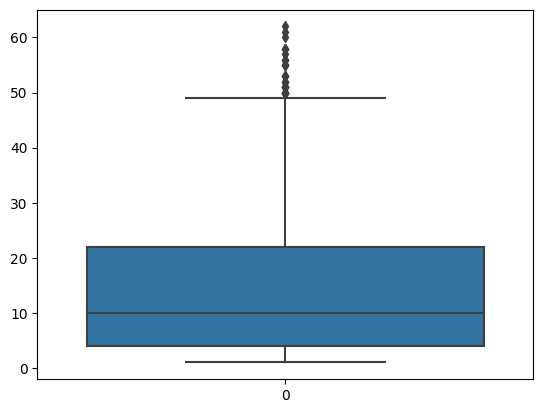

In [6]:
df_items = df_data[['item_id', 'user_id']].groupby(['item_id']).nunique().reset_index()
sns.boxplot(df_items['user_id'])

In [7]:
# filtering items where provided count >10
sample_items = list(df_items.loc[df_items['user_id']>10, "item_id"])
df_grouped = df_grouped.loc[df_grouped['item_id'].isin(sample_items)]

## EDA

### 1. cosine similarity & euclidean distance
| `User` 간 동일-경험 집합에서 각각 선택 집합과 집합 내 요소 각각의 선정 확률을 기준으로 `User`간 유사도 측정이 가능할까?

- $set(A)$: user A가 경험한 item의 전체 집합
- $set(B)$: user B가 경험한 item의 전체 집합
- $set(A) \bigcap\ set(B)$: user A & user B 모두 경험한 item 집합
- $P(A)$: user A가 경험한 item들에 대한 선택 확률 집합
- $set(A) \bigcap\ set(B)$ 에서 동일 선택 항목을 바탕으로 `cosine similarity` 적용
- $set(A) \bigcap\ set(B)$ 에서 항목별 선택확률을 바탕으로 `euclidean distance` 적용

In [42]:
def make_group_cos(value):
    res = dict()
    data = value.to_dict(orient='records')
    for row in data:
        res[row['item_id']] = row['ratio']
    return res

cos_records = df_grouped.groupby('user_id').apply(make_group_cos)
cos_records = cos_records.to_dict()

In [47]:
def get_cosine_similarity(target:dict, check:dict):
    intersection_items = set(list(target.keys())).intersection(list(check.keys()))
    if len(intersection_items) == 0:
        return None
    list_target = [target.get(idx) - 0.5 for idx in intersection_items]
    list_check = [check.get(idx) - 0.5 for idx in intersection_items]
    if np.linalg.norm(list_target)*np.linalg.norm(list_check) == 0:
        return None
    return np.dot(list_target,list_check)/(np.linalg.norm(list_target)*np.linalg.norm(list_check))


<AxesSubplot: >

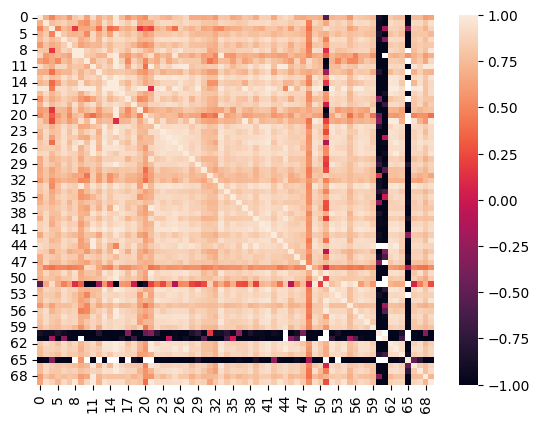

In [48]:
res_cos = dict()
for target_idx, target_user in cos_records.items():
    check_data =dict()
    for check_idx, check_user in cos_records.items():
        check_data[check_idx] = get_cosine_similarity(target_user, check_user)
    res_cos[target_idx] = check_data

df_cos = pd.DataFrame(res_cos)
sns.heatmap(df_cos)

In [49]:
def make_group_euc(value):
    return dict(zip(value['item_id'], value['score']))

euc_records = df_grouped.copy()
euc_records['score'] = euc_records['join_cnt'] - euc_records['reject_cnt']

euc_records = euc_records.groupby(by='user_id').apply(make_group_euc)

In [50]:
def get_euclidean(target:dict, check:dict):
    intersection_items = set(list(target.keys())).intersection(list(check.keys()))
    if intersection_items == None:
        return None
    list_target = [target.get(idx) for idx in intersection_items]
    list_check = [check.get(idx) for idx in intersection_items]
    return np.linalg.norm(np.array(list_target) - np.array(list_check))

<AxesSubplot: >

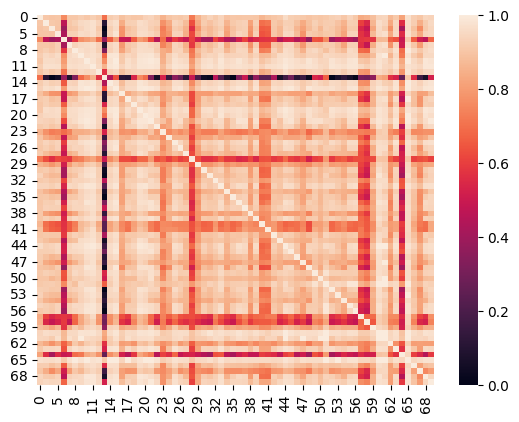

In [62]:
res_euc = dict()
for target_idx in euc_records.keys():
    res_euc_check = dict()
    for check_idx in euc_records.keys():
        res_euc_check[check_idx] = get_euclidean(euc_records[target_idx], euc_records[check_idx])
    res_euc[target_idx] = res_euc_check

df_euc = pd.DataFrame(res_euc)

# apply scaler to df
# transform score to range between 0 and 1 and make reverse array
max_num = df_euc.max().max()
min_num = df_euc.min().min()
df_euc = df_euc.loc[:,:].apply(lambda x: 1-((x-min_num)/(max_num-min_num)))

sns.heatmap(df_euc)

/var/folders/5v/97lsv0mn5_zf34hm9v9g4_kc0000gn/T/ipykernel_24648/3853483109.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for index_, idx in enumerate(df_cos[target].sort_values(ascending=False)[1:10].keys()):


Text(0.5, 0.98, 'Target is 0')

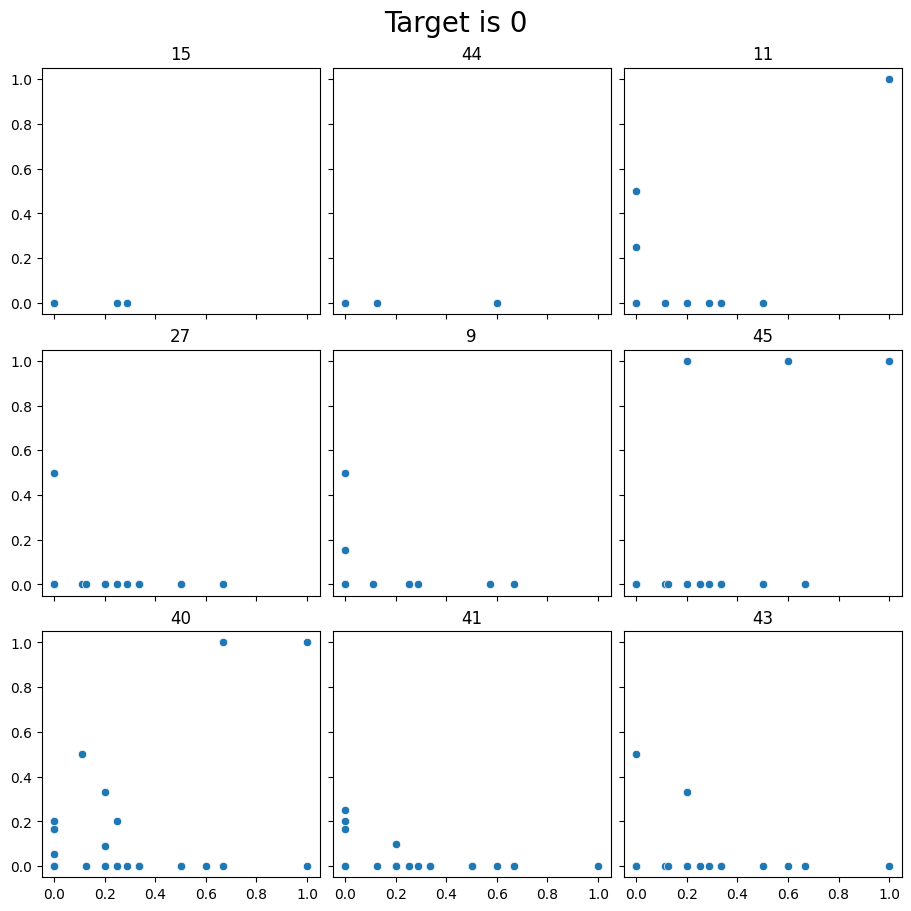

In [71]:
fig, axes = plt.subplots(3,3, figsize=(9,9), sharex=True, sharey=True, constrained_layout=True)
target = 0
for index_, idx in enumerate(df_cos[target].sort_values(ascending=False)[1:10].keys()): 
    sns.scatterplot(
        ax= axes[index_//3, index_%3],
        data=df_grouped.loc[df_grouped['user_id'].isin([target,idx])].pivot(index='item_id', columns='user_id', values='ratio').dropna(),
        x=target,
        y=idx,
    ).set(title=idx, ylabel=None, xlabel=None)

fig.suptitle(f"Target is {target}", fontsize=20)

/var/folders/5v/97lsv0mn5_zf34hm9v9g4_kc0000gn/T/ipykernel_24648/703256993.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  for index_, idx in enumerate(df_euc[target].sort_values(ascending=False)[1:10].keys()):


Text(0.5, 0.98, 'Target is 0')

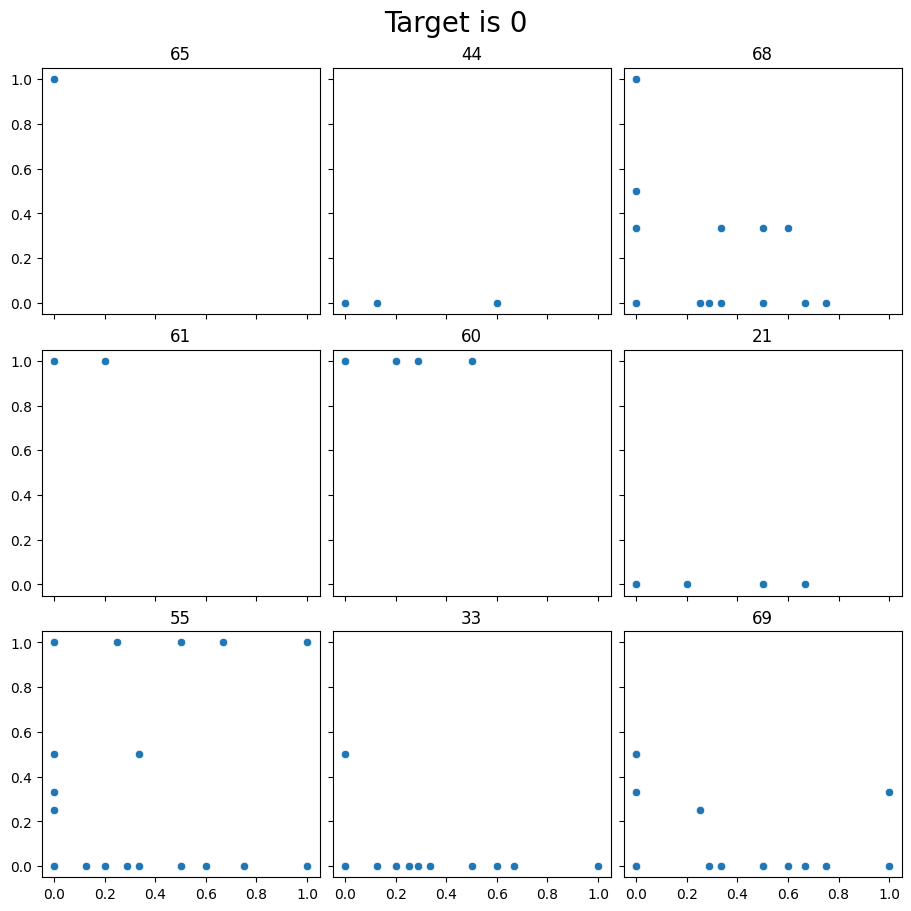

In [76]:
fig, axes = plt.subplots(3,3, figsize=(9,9), sharex=True, sharey=True, constrained_layout=True)
target = 0
for index_, idx in enumerate(df_euc[target].sort_values(ascending=False)[1:10].keys()): 
    sns.scatterplot(
        ax= axes[index_//3, index_%3],
        data=df_grouped.loc[df_grouped['user_id'].isin([target,idx])].pivot(index='item_id', columns='user_id', values='ratio').dropna(),
        x=target,
        y=idx,
    ).set(title=idx, ylabel=None, xlabel=None)

fig.suptitle(f"Target is {target}", fontsize=20)

In [98]:
index_to_id = {index_:idx for index_, idx in enumerate(df_cos.index)}
result = (np.array(df_cos) + np.array(df_euc))/2
result


array([[1.        , 0.80080971, 0.69373275, ..., 0.82455926, 0.77113255,
        0.78599523],
       [0.80080971, 1.        , 0.83546244, ..., 0.87335261, 0.85690548,
        0.94504856],
       [0.69373275, 0.83546244, 1.        , ..., 0.78957199, 0.81048348,
        0.90823724],
       ...,
       [0.82455926, 0.87335261, 0.78957199, ..., 1.        , 0.76120804,
        0.85209828],
       [0.77113255, 0.85690548, 0.81048348, ..., 0.76120804, 1.        ,
        0.83338639],
       [0.78599523, 0.94504856, 0.90823724, ..., 0.85209828, 0.83338639,
        1.        ]])

In [109]:
tlst = [(index_, value) for index_, value in enumerate(result[0])]
tlst.sort(key=lambda x: x[1], reverse=True)
tlst

[(0, 1.0),
 (13, 0.9550089676175999),
 (42, 0.9402111620043271),
 (9, 0.9176107945341383),
 (25, 0.9045862013663497),
 (7, 0.901608720733402),
 (43, 0.8935834321621918),
 (19, 0.8870764691129713),
 (41, 0.8784664991551392),
 (54, 0.8757116726660397),
 (31, 0.8722390405736404),
 (39, 0.8679338901991936),
 (24, 0.8664278602344992),
 (38, 0.8596819827386373),
 (20, 0.8588325480608456),
 (23, 0.8567466107611937),
 (35, 0.8544619436994708),
 (6, 0.8536611598330384),
 (60, 0.8468123156335832),
 (51, 0.8424122085223529),
 (36, 0.840894656876602),
 (32, 0.840641522024959),
 (64, 0.8359895352297532),
 (61, 0.8336765486788127),
 (65, 0.8245592613526029),
 (55, 0.8230646267850115),
 (14, 0.8196701643239868),
 (56, 0.8192922734245774),
 (50, 0.8181910971488631),
 (52, 0.8160088851482825),
 (12, 0.8150652848868207),
 (57, 0.8109077782009215),
 (47, 0.8107729915290832),
 (29, 0.8048091844187863),
 (3, 0.802326629593553),
 (1, 0.8008097087831836),
 (46, 0.8005020729862665),
 (34, 0.8004063232676831),

Text(0.5, 0.98, 'Target is 0')

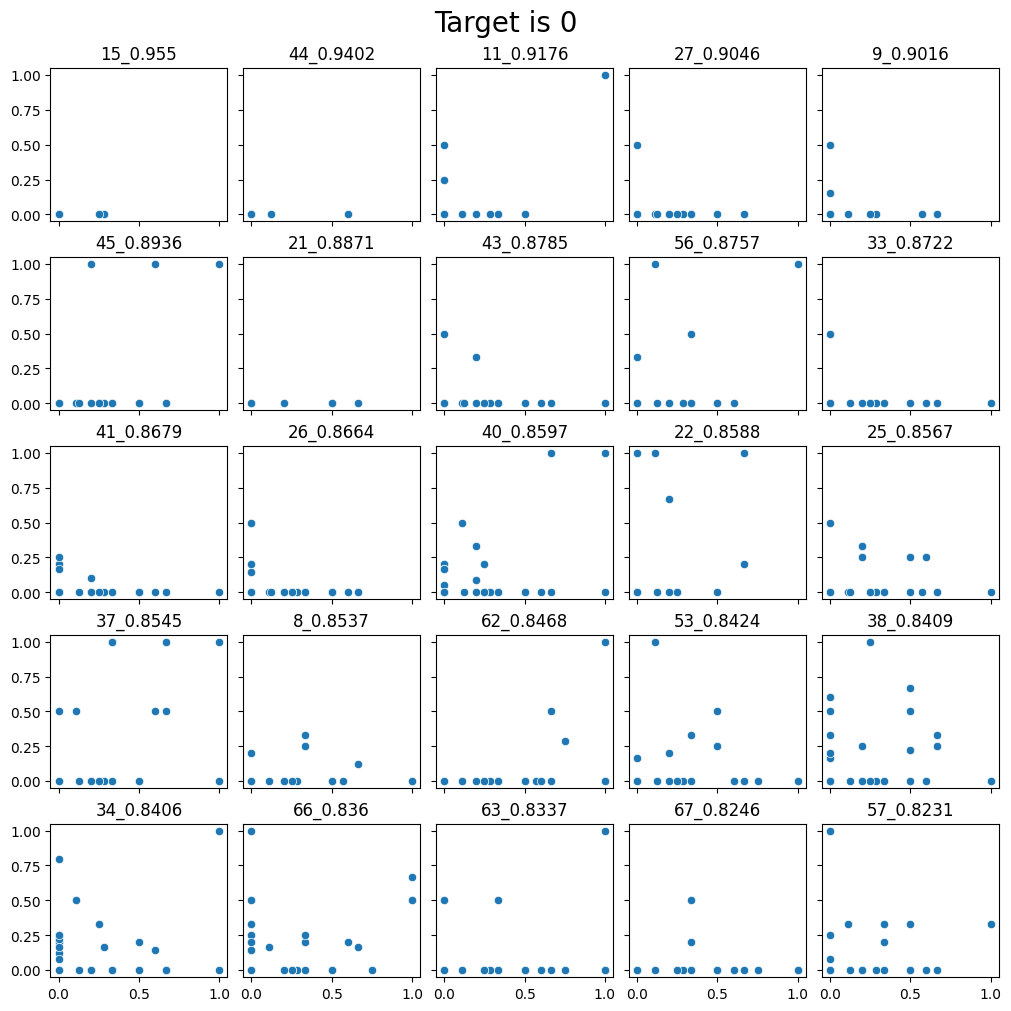

In [120]:
show_num = 5
fig, axes = plt.subplots(show_num,show_num, figsize=(10,10), sharex=True, sharey=True, constrained_layout=True)
target = 0

tlst = [(index_, value) for index_, value in enumerate(result[0])]
tlst.sort(key=lambda x: x[1], reverse=True)
tlst

plt_num = 0
for index_, idx in tlst[1:show_num*show_num+1]:
    sns.scatterplot(
        ax= axes[plt_num//show_num, plt_num%show_num],
        data=df_grouped.loc[df_grouped['user_id'].isin([target,index_to_id[index_]])].pivot(index='item_id', columns='user_id', values='ratio').dropna(),
        x=target,
        y=index_to_id[index_],
    ).set(title=f"{index_to_id[index_]}_{round(idx,4)}", ylabel=None, xlabel=None)
    plt_num += 1

fig.suptitle(f"Target is {target}", fontsize=20)